# Analiza preprocessingu z artykułu

In [67]:
import os

import numpy as np
import nibabel as nib
import glob

import matplotlib.pyplot as plt

## Kod twórców

In [68]:
from scipy.ndimage.morphology import binary_erosion, binary_fill_holes

# Functions
def hu_to_grayscale(volume):
    volume = np.clip(volume, -512, 512)
    mxval  = np.max(volume)
    mnval  = np.min(volume)
    im_volume = (volume - mnval)/max(mxval - mnval, 1e-3)
    im_volume = im_volume
    return im_volume *255

def get_mask_alung(vol):
    vol_im = np.where(vol>0, 1, 0)
    shp    = vol.shape
    around_lung = np.zeros((shp[0], shp[1], shp[2]), dtype=np.float32)
    for idx in range(shp[0]):
            around_lung[idx, :, :] = binary_erosion(vol_im[idx], structure=np.ones((15,15))).astype(vol_im.dtype)
            
    return around_lung

def get_mask(segmentation):
    # initialize output to zeros
    shp    = segmentation.shape
    lung = np.zeros((shp[0], shp[1], shp[2]), dtype=np.float32)
   
    # Get mask for kidney and tumor
    lung[np.equal(segmentation,255)] = 255
    return lung
    
def get_FOV(around_lung, lung):
    FOV = np.where((around_lung + lung) >0, 1, 0)
    for idx in range(FOV.shape[0]):
        FOV[idx, :, :] = binary_fill_holes(FOV[idx, :, :], structure=np.ones((5,5))).astype(FOV.dtype)
    return FOV

def return_axials(vol, seg):

    # Prepare segmentation and volume
    vol = vol.get_data()
    seg = seg.get_data()
    seg = seg.astype(np.int32)
    
    # Convert to a visual format
    vol_ims = hu_to_grayscale(vol)
    lung    = get_mask(seg)
    around_lung = get_mask_alung(vol_ims)
    FOV = get_FOV(around_lung, lung)
    around_lung = np.where((FOV - lung) >0, 1, 0)

    return vol_ims, lung, around_lung, FOV

In [3]:
# Define Train data and mask
Data_train = []
Mask_train = []
Maska_train = []
FOV_train = []

In [4]:
Tr_add = '3d_images'

Tr_list = glob.glob(Tr_add + '/*.gz')

In [ ]:
idx_count = 1

for idx in range(len(Tr_list)):
    b = Tr_list[idx]
    a = b[len(Tr_add) + 1:len(Tr_add) + 4]
    if a == 'IMG':
        print(idx_count)
        a = b[len(Tr_add) + 5:len(b)]
        add = (Tr_add + '/MASK_' + a)
        vol = nib.load(Tr_list[idx])
        seg = nib.load(add)
        # Get the axials images and corresponding masks
        vol_ims, lung, around_lung, FOV = return_axials(vol, seg)
        segmentation = seg.get_data()
        # Insert samples to the Train data, which has the segmentation label
        for idx in range(vol.shape[0]):
            if ~(np.sum(segmentation[idx, :, :]) == 0):
                Data_train.append(vol_ims[idx, :, :])
                Mask_train.append(lung[idx, :, :])
                Maska_train.append(around_lung[idx, :, :])
                FOV_train.append(FOV[idx, :, :])
        idx_count += 1        

Widzimy, że w pętli wczytywane są wszystkie zdjęcia oraz odpowiadające im maski.
Następnie każde zdjęcie oraz maska jest przerabiane przez funkcję `return_axials()`, którą rozłożymy na czynniki pierwsze.

## funkcja `hue_to_grayscale()`
1. Przyjmuje listę obrazów przekrojów płuc.
2. Następnie ogranicza wartości pikseli w obrazie do przedziału [-512, 512], wartości mniejsze od -512 zamieniane są na -512, większe od 512 na 512.
3. Normalizuje wartości pikseli, tak by przyjmowały wartości z przedziału [0, 1].
4. Przemnaża wartość każdego piksela przez 255. 

In [71]:
img_bf = nib.load(Tr_list[1])
img_bf = img_bf.get_fdata()

In [72]:
img_af = hu_to_grayscale(img_bf)

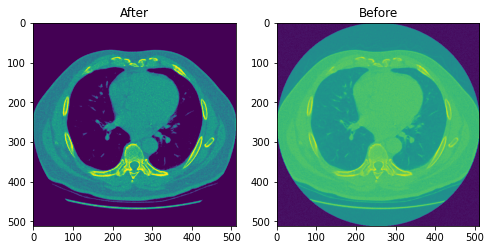

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img_af[200])
ax[1].imshow(img_bf[200])

ax[0].set_title('After')
ax[1].set_title('Before')
plt.show()

## funkcja `get_mask()`
1. Przyjmuje listę masek płuc.
2. Tworzy macierz w rozmiarze jednego obrazu wypełnioną zerami.
3. Tam gdzie maska przyjmuje wartosci 255 wpisuje do macierzy 255.
4. Zmodyfikowana macierz jest zwracana.

In [80]:
mask_bf = nib.load(Tr_list[5])
mask_bf = mask_bf.get_fdata()

mask_af = get_mask(mask_bf)

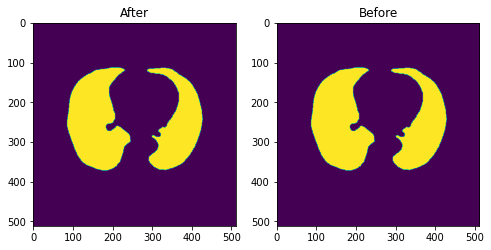

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(mask_af[200])
ax[1].imshow(mask_bf[200])

ax[0].set_title('After')
ax[1].set_title('Before')
plt.show()

## funkcja `get_mask_alung()`
1. Przyjmuje listę obrazów płuc.
2. Wszystkie wartości większe od 0 zastępuje jedynkami.
3. Tworzy macierz zer w rozmiarze listy zdjęć.
4. Na każdym obrazie stosuje `binary_erosion`.

Zobaczmy jak na powstałą maskę wpłyną zmiany parametrów w `binary_erosion`.

In [85]:
def get_mask_alung_mdf(vol):
    vol_im = np.where(vol>0, 1, 0)
    shp    = vol.shape
    around_lung = np.zeros((shp[0], shp[1], shp[2]), dtype=np.float32)
    for idx in range(shp[0]):
            around_lung[idx, :, :] = binary_erosion(vol_im[idx], structure=np.ones((5,5))).astype(vol_im.dtype)
            
    return around_lung
mask_alung_mdf = get_mask_alung_mdf(img_af)

In [82]:
mask_alung = get_mask_alung(img_af)

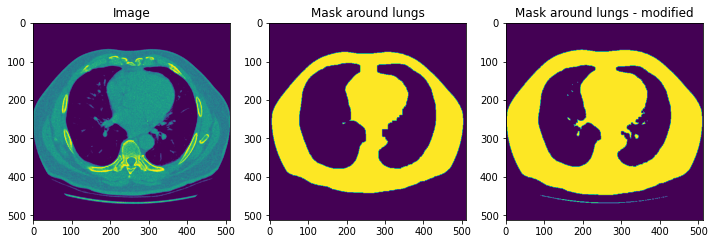

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(img_af[200])
ax[1].imshow(mask_alung[200])
ax[2].imshow(mask_alung_mdf[200])

ax[0].set_title('Image')
ax[1].set_title('Mask around lungs')
ax[2].set_title('Mask around lungs - modified')
plt.show()

Zmniejszenie `structure` na macierz 5 x 5 sprawia, że obraz jest dużo dokładniejszy. Jednak domyślamy się, że autorzy chcieli pozbyć się punktów z wnętrza płuc, które mogły negatywnie wpływać na uczenie się sieci neuronowej.

## funkcja `get_FOV()`
1. Przyjmuje listę masek otaczających płuca i płuc.
2. Następnie tam gdzie po nałożeniu na siebie maski otaczającej i maski płuc, mamy piksel o wartości dodatniej zostały wpisane jedynki.
3. Tak przygotowane obrazy zostały potraktowane funkcją `binary_fill_holes()`.

Ponownie wprowadźmy modyfikację do funkcji `binary_fill_holes()` i zobaczmy co się stanie.

In [106]:
def get_FOV_mdf(around_lung, lung):
    FOV = np.where((around_lung + lung) >0, 1, 0)
    for idx in range(FOV.shape[0]):
        FOV[idx, :, :] = binary_fill_holes(FOV[idx, :, :], structure=np.ones((2,2))).astype(FOV.dtype)
    return FOV

In [107]:
FOV = get_FOV(mask_alung, mask_af)
FOV_mdf = get_FOV_mdf(mask_alung, mask_af)

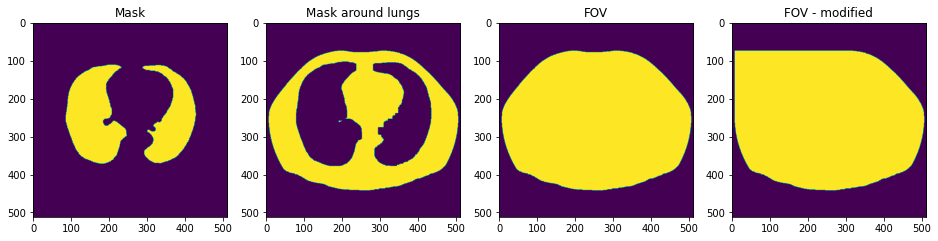

In [108]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].imshow(mask_af[200])
ax[1].imshow(mask_alung[200])
ax[2].imshow(FOV[200])
ax[3].imshow(FOV_mdf[200])

ax[0].set_title('Mask')
ax[1].set_title('Mask around lungs')
ax[2].set_title('FOV')
ax[3].set_title('FOV - modified')
plt.show()

Przy zwiększaniu parametru `structure` nie zauważamy żadnych zmian. Nastomiast zmniejszanie go skutkuje zaburzeniem kształtu przekroju ciała człowieka.

## funkcja `return_axials()`
1. Wywołuje powyżej wymienione funkcje.
2. Ponadto modyfikuje jeszcze maskę otaczającą płuca.
`mask_alung = np.where((FOV - mask_af) >0, 1, 0)`
3. Zwraca img_af, mask_af, mask_alung_final oraz FOV.

In [109]:
mask_alung_final = np.where((FOV - mask_af) >0, 1, 0)

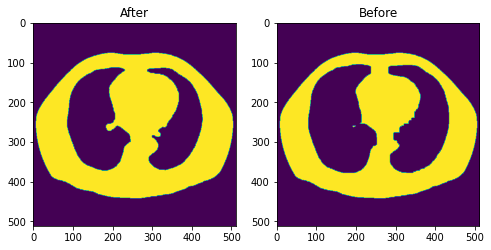

In [110]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(mask_alung_final[200])
ax[1].imshow(mask_alung[200])

ax[0].set_title('After')
ax[1].set_title('Before')
plt.show()